# RQ3: How does the CNN perform on different image tasks and datasets?

## Experiment 2: Performance on multi-class classification

**Dataset I: Brain Tumor MRI dataset:**<br>
This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. No tumor class images were taken from the Br35H dataset. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

**Dataset II: CE-MRI dataset:**<br>
This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor: meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). You can find it [here](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

## Import Necessary Modules

In [1]:
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(42)          # Python's random module
np.random.seed(42)       # NumPy (used by scikit-learn)
tf.random.set_seed(42)   # TensorFlow/Keras

In [2]:
# Now proceed with other imports
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import os
from os import listdir
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

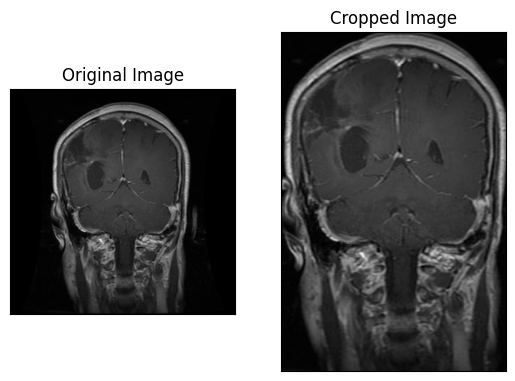

In [4]:
ex_img = cv2.imread('data/brain-tumor-mri/Training/glioma/Tr-gl_0010.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size, categories):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for label, category in enumerate(categories):
        folder_path = os.path.join(dir_list, category)
        for filename in listdir(folder_path):
            # load the image
            image = cv2.imread(folder_path + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            y.append(label)
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

### Choose the dataset to train and evaluate the model on

In [6]:
# Dataset 1
augmented_training = 'data/brain-tumor-mri/Training/'
augmented_test = 'data/brain-tumor-mri/Testing/'
augmented_path = 'data/brain-tumor-mri/'
categories = ['meningioma', 'glioma', 'pituitary', 'notumor']

# Dataset 2
# augmented_path = 'data/ce-mri/'
# categories = ['meningioma', 'glioma', 'pituitary']

In [7]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

if augmented_path == 'data/ce-mri/':
    X, y = load_data(augmented_path, (IMG_WIDTH, IMG_HEIGHT), categories)

else:
    X_train, y_train = load_data(augmented_training, (IMG_WIDTH, IMG_HEIGHT), categories)
    X_test, y_test = load_data(augmented_test, (IMG_WIDTH, IMG_HEIGHT), categories)

Number of examples is: 5712
X shape is: (5712, 240, 240, 3)
y shape is: (5712,)
Number of examples is: 1311
X shape is: (1311, 240, 240, 3)
y shape is: (1311,)


Each image has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [9]:
def plot_sample_images(X, y, labels):
    """
    Plots one sample image for each unique label side by side in the same figure.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        labels: A list of unique labels to consider
    """
    
    plt.figure(figsize=(len(labels) * 5, 5))  # Adjust figure size dynamically
    
    for i, label in enumerate(labels):
        # Grab the first image with the corresponding y value equal to label
        image = X[np.argwhere(y == label)][0][0]  # Extract the first matching image
        
        plt.subplot(1, len(labels), i + 1)
        plt.imshow(image)
        
        # Remove ticks
        plt.axis("off")
        
        # Define label names

        label_to_str = lambda l: "Meningioma" if l == 0 else "Glioma" if l == 1 else "Pituitary" if l == 2 else "No Tumor"
        
        plt.title(f"Brain Tumor: {label_to_str(label)}")
    
    plt.show()


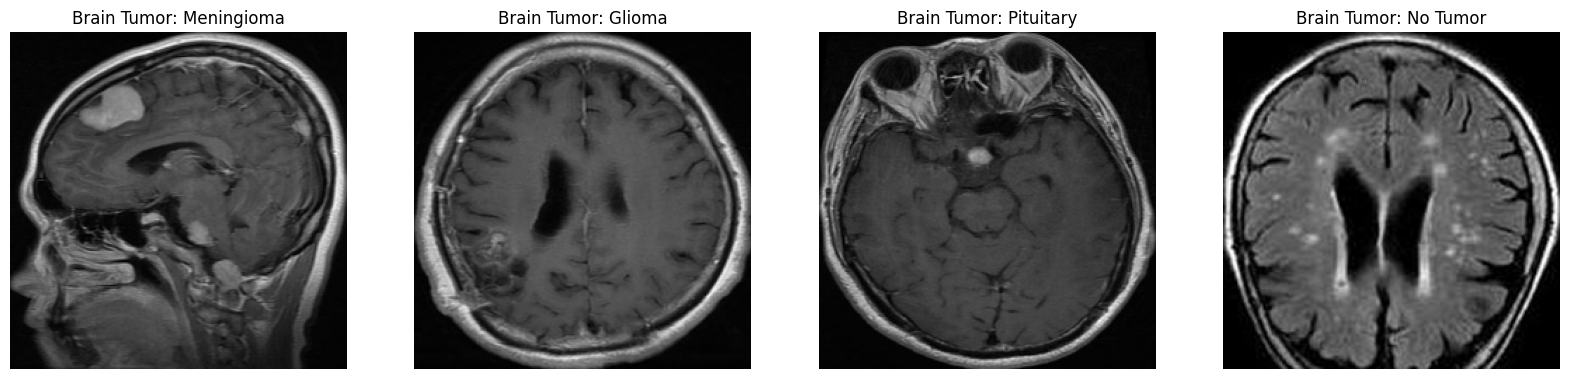

In [10]:
if augmented_path == 'data/ce-mri/':
    plot_sample_images(X, y, labels=[0, 1, 2])
else:
    plot_sample_images(X_train, y_train, labels=[0, 1, 2, 3])

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [11]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, y_train, X_val, y_val

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 10% of the data for validation.
3. 20% of the data for testing.

In [12]:
if augmented_path == 'data/ce-mri/':
    X_train, y_train, X_test_val, y_test_val = split_data(X, y, test_size=0.3)
    X_test, y_test, X_val, y_val = split_data(X_test_val, y_test_val, test_size=0.5)
else:
    X_train, y_train, X_val, y_val = split_data(X_train, y_train, test_size=0.125)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 4998
number of development examples = 714
number of test examples = 1311
X_train shape: (4998, 240, 240, 3)
Y_train shape: (4998,)
X_val (dev) shape: (714, 240, 240, 3)
Y_val (dev) shape: (714,)
X_test shape: (1311, 240, 240, 3)
Y_test shape: (1311,)


Some helper functions:

In [14]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
def compute_f1_score(y_true, best_model, X_test):
    # convert the vector of probabilities to a target vector
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    
    score = f1_score(y_true, y_pred, average='weighted')
    
    return score

In [16]:
def evaluate(model):
    model.metrics_names
    loss, acc = model.evaluate(x=X_test, y=y_test)
    val_loss, val_acc = model.evaluate(x=X_val, y=y_val)

    f1score_val = compute_f1_score(y_val, model, X_val)

    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, model, X_test)

    print (f"Test Loss = {loss}")
    print (f"Test Accuracy = {acc}")
    print (f"Val Loss = {val_loss}")
    print (f"Val Accuracy = {val_acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

    return y_test_prob, acc

# Build the model

Let's build a convolutional neural network model:

In [17]:
def build_model(input_shape, output_labels):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(output_labels, activation='softmax', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [20]:
model = build_model(IMG_SHAPE, len(categories))

In [21]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 4)              │        25,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,956 (117.02 KB)

 Trainable params: 29,892 (116.77 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_dir = f"models/"
os.makedirs(model_dir, exist_ok=True)

if augmented_path == 'data/ce-mri/':
    dataset_path="dataset_2"
else:
    dataset_path="dataset_1"

# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, f"multiclass_{dataset_path}.keras")

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

## Train the model

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=2, validation_data=(X_val, y_val), callbacks=[checkpoint], shuffle=True, verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 124s 774ms/step - accuracy: 0.5774 - loss: 1.5248 - val_accuracy: 0.3333 - val_loss: 1.3324
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 730ms/step - accuracy: 0.8009 - loss: 0.5441 - val_accuracy: 0.4902 - val_loss: 1.2735
Elapsed time: 0:4:46.1


In [25]:
history = model.history.history

In [26]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [27]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

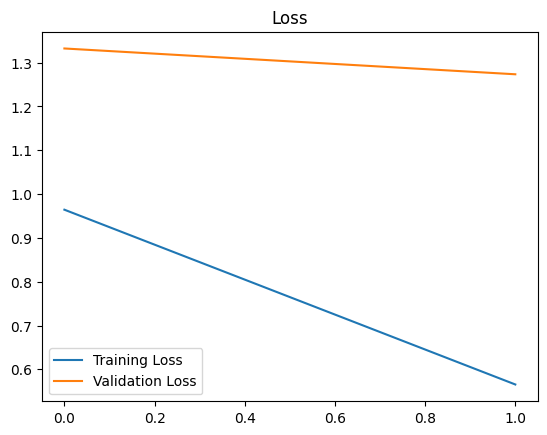

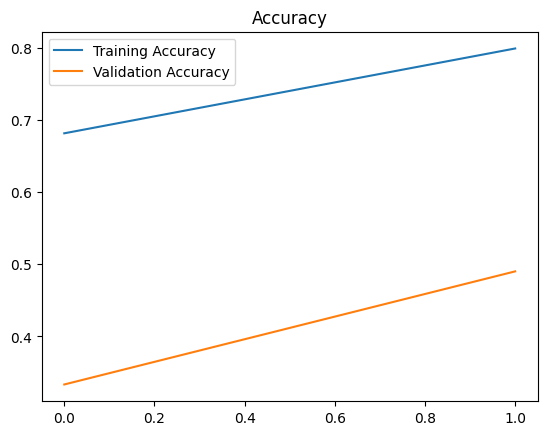

In [28]:
plot_metrics(history) 

# Results

### Load the best model

In [29]:
best_model = load_model(filepath=f'models/multiclass_{dataset_path}.keras')

In [30]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [31]:
y_test_prob, acc = evaluate(best_model)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4570 - loss: 1.3781
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4696 - loss: 1.3154
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step
Test Loss = 1.4051200151443481
Test Accuracy = 0.444698691368103
Val Loss = 1.2734637260437012
Val Accuracy = 0.4901960790157318
Val F1 Score: 0.4955689801367185
Test F1 Score: 0.4256798662271415


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [33]:
def data_percentage(y):
    
    class_labels = np.unique(y)

    for label in class_labels:
        percentage = (len(y[y == label]) / len(y)) * 100
        print(f"Label {label} makes up {percentage:.2f}% of the data.")


In [34]:
# the whole data
data_percentage(np.concatenate([y_train, y_val, y_test], axis=0))

Label 0 makes up 23.42% of the data.
Label 1 makes up 23.08% of the data.
Label 2 makes up 25.02% of the data.
Label 3 makes up 28.48% of the data.


In [35]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Label 0 makes up 23.89% of the data.
Label 1 makes up 23.27% of the data.
Label 2 makes up 25.21% of the data.
Label 3 makes up 27.63% of the data.
Validation Data:
Label 0 makes up 20.31% of the data.
Label 1 makes up 22.13% of the data.
Label 2 makes up 27.59% of the data.
Label 3 makes up 29.97% of the data.
Testing Data:
Label 0 makes up 23.34% of the data.
Label 1 makes up 22.88% of the data.
Label 2 makes up 22.88% of the data.
Label 3 makes up 30.89% of the data.


As expected, the percentage of positive examples are around 50%.

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
[[299   4   1   2]
 [160 139   1   0]
 [235  16  49   0]
 [300   4   5  96]]


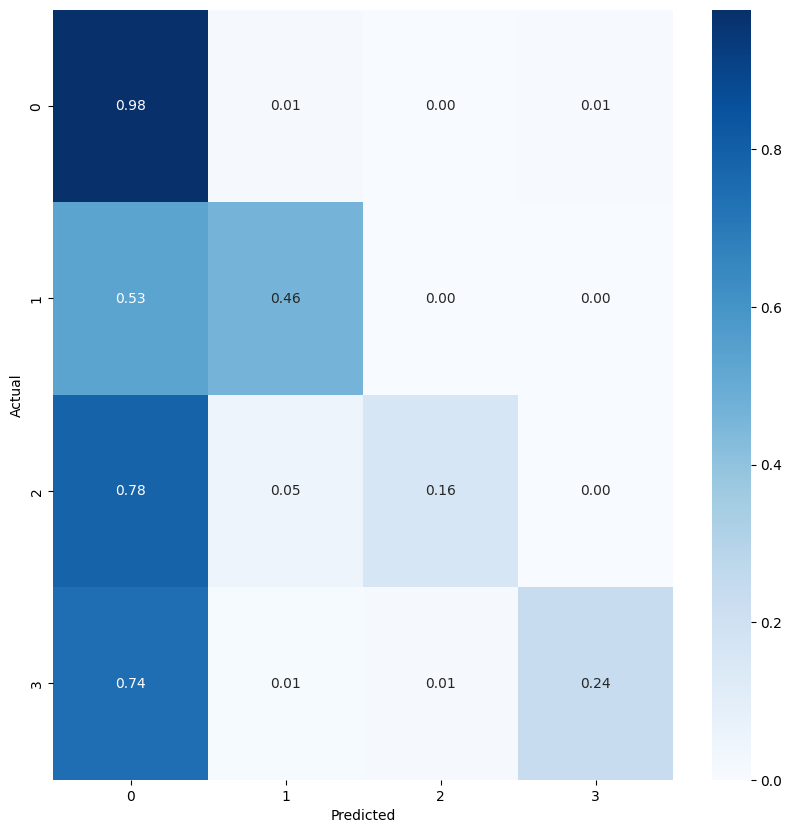

In [36]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    
    # Get confusion matrix
    cm  = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

y_pred = np.argmax(best_model.predict(X_test), axis=1)
plot_confusion_matrix(y_test, y_pred)

# Analysis

### Display some of the images that were classified correctly and incorrectly:

In [37]:
# Display some of the misclassified images
def display_misclassified_images(X, y, y_pred):
    """
    Display the images that were misclassified by the model.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        y_pred: A numpy array with shape = (#_examples, 1)
    """
    
    # Get the indices of the misclassified images
    misclassified = np.where(y != y_pred)[0]
    
    # Choose the first 5 indices
    selected = misclassified[:5]
    
    plt.figure(figsize=(10, 5))
    
    for i, idx in enumerate(selected, 1):
        plt.subplot(1, 5, i)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title(f"True: {y[idx]}\nPredicted: {y_pred[idx]}")
    
    plt.show()

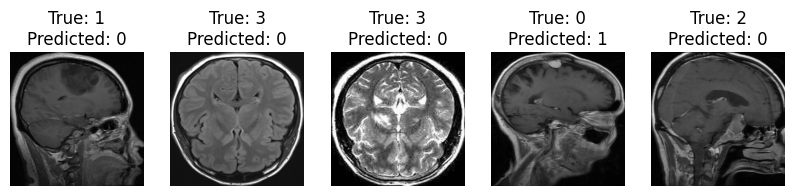

In [38]:
display_misclassified_images(X_test, y_test, y_pred)

# Conclusion

**Performance Table:**

| Metric     | Dataset 1 (Validation) | Dataset 1 (Test) | CE-MRI (Validation) | CE-MRI (Test) |
|-----------|-----------------------|------------------|-----------------------|------------------|
| Accuracy  | 86%                   | 88%              | 92%                   | 92%              |
| F1 Score  | 0.81                  | 0.88             | 0.92                  | 0.92             |
